# Deep (nonlinear) autoencoder
* Deep stack of nonlinear layers can reconstruct shapes from less latent neurons.
* The latent activations are correlated.

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import dataset

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
nepochs = 600       # DAE needs to train longer for convergence.
ncomponents = 3
batch_size = 32     # Small batch sizes work better for DAE.

### 1. Generate data

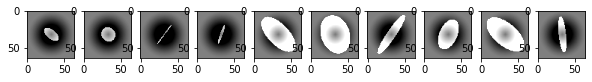

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "ellipse")
X = data - data.mean(axis=0) # center data: same input data as PCA.

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X[i], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 2. Create model
* We use sigmoid activation.
* ReLU only works when bias is on (might be because centering the data around 0 gives lots of negative values, which relu cuts away). 

In [4]:
encoder = keras.Sequential([
    keras.layers.Input(shape=(nrows*ncols,)),
    keras.layers.Dense(units=64, activation='sigmoid', use_bias=False),
    keras.layers.Dense(units=32,  activation='sigmoid', use_bias=False),
    keras.layers.Dense(units=ncomponents, activation='linear', use_bias=False)
])
decoder = keras.Sequential([
    keras.layers.Input(shape=(ncomponents,)),
    keras.layers.Dense(units=32, activation='sigmoid', use_bias=False),
    keras.layers.Dense(units=64, activation='sigmoid', use_bias=False),
    keras.layers.Dense(units=nrows*ncols, activation='linear', use_bias=False)
])

dae = keras.Sequential([encoder, decoder])
dae.compile(loss='mse', optimizer='adam')

### 3. Train model

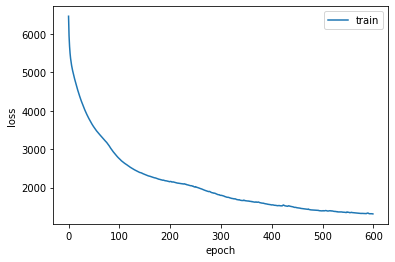

In [5]:
history = dae.fit(X, X, epochs=nepochs, batch_size=batch_size, verbose=0)
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space

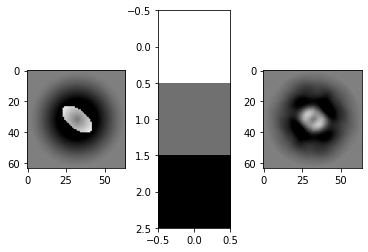

In [6]:
Z = encoder(X)
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space

In [7]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]
sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=1.3068206310272217, description='PC1', max=11.620006561279297, min=-8.…

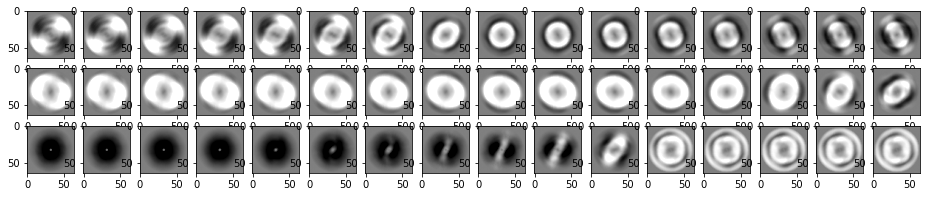

In [8]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx])
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of DAE

Dot product of all encoder weights:
 [[105.22514  -6.05473  -6.41356 ...  49.87798 -10.28134  38.92633]
 [ -6.05473  98.09497  32.0572  ...  -2.59606   4.20952  -8.29678]
 [ -6.41356  32.0572  101.85201 ...  -9.10507  27.71176 -19.70501]
 ...
 [ 49.87798  -2.59606  -9.10507 ... 113.20837   7.22686  25.4464 ]
 [-10.28134   4.20952  27.71176 ...   7.22686  45.20429 -14.64528]
 [ 38.92633  -8.29678 -19.70501 ...  25.4464  -14.64528  65.515  ]]
===> Weights are neither orthogonal nor unit norm.
Cov of latent activations:
 tf.Tensor(
[[ 7.4367857   0.63313884 -0.61124873]
 [ 0.63313884 12.24362    -2.9819767 ]
 [-0.61124873 -2.9819767  25.83482   ]], shape=(3, 3), dtype=float32)
===> Latent components are heavily correlated.


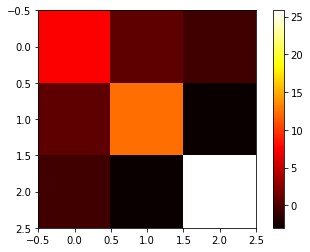

In [9]:
pcs = encoder.weights[0]
I = (tf.transpose(pcs) @ pcs)
print("Dot product of all encoder weights:\n", np.round(I, 5))
print("===> Weights are neither orthogonal nor unit norm.")

fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();
print("===> Latent components are heavily correlated.")

### 7. Calculate MSE

In [10]:
X_pred = dae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  1313.3518
